# 주요 변수(Key Features) 영향력 검증 분석



**분석 목표:**
1. 왜 **할인액**이 가장 중요한 변수인가?
2. **무게**는 어떤 구간에서 지연이 발생하는가?
3. **제품 중요도** 높음(High)은 실제로 지연과 관련이 있는가?
4. 무의미하다고 판단된 변수(**성별, 창고**)는 왜 그런가?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 한글 폰트 설정
if os.name == 'nt':
    plt.rc('font', family='Malgun Gothic')
elif os.name == 'posix':
    plt.rc('font', family='AppleGothic')
else:
    print("Unknown OS")

plt.rc('axes', unicode_minus=False)
sns.set_palette("Set2")
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 데이터 로드
df = pd.read_csv('data/Train.csv')
if 'Reached.on.Time_Y.N' in df.columns:
    df = df.rename(columns={'Reached.on.Time_Y.N': 'target'})

display(df.head())

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,target
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


## 1. 할인액 (Discount_offered) 분석
**근거:** 할인액이 특정 구간을 넘어가면 지연율이 급격히 변동하는지 확인합니다.

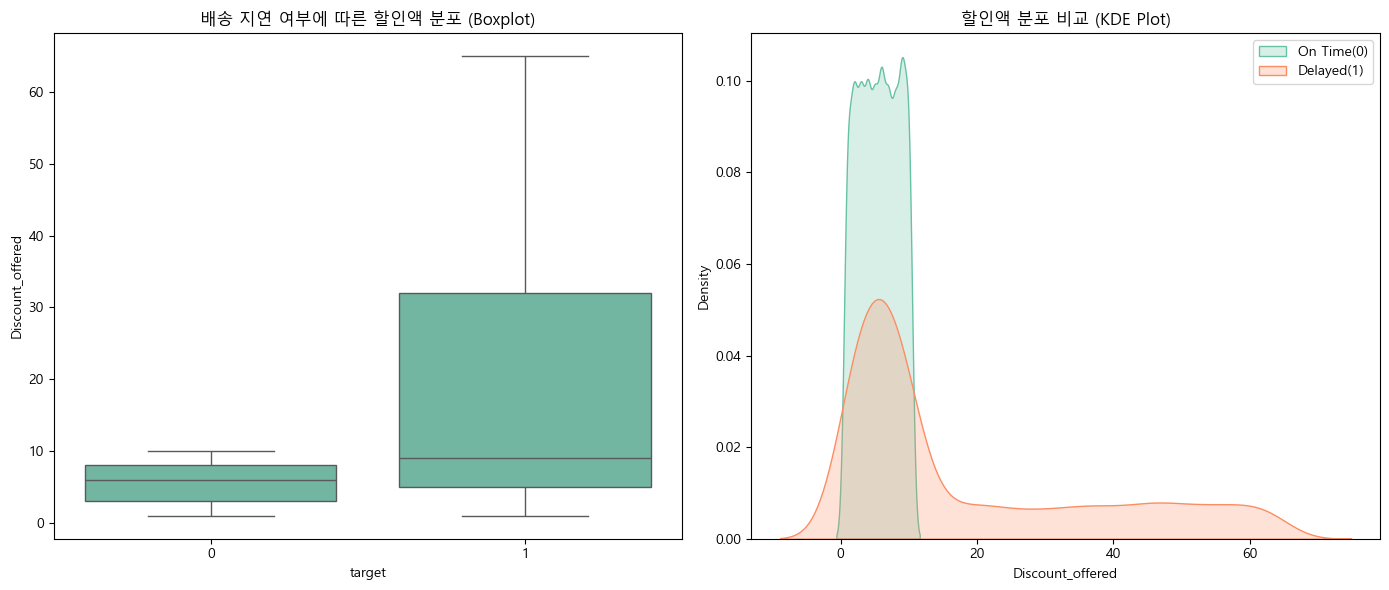

In [3]:
plt.figure(figsize=(14, 6))

# 1. Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='target', y='Discount_offered', data=df)
plt.title('배송 지연 여부에 따른 할인액 분포 (Boxplot)')

# 2. KDE Plot (밀도 그래프)
plt.subplot(1, 2, 2)
sns.kdeplot(df[df['target'] == 0]['Discount_offered'], label='On Time(0)', shade=True)
sns.kdeplot(df[df['target'] == 1]['Discount_offered'], label='Delayed(1)', shade=True)
plt.title('할인액 분포 비교 (KDE Plot)')
plt.legend()

plt.tight_layout()
plt.show()

> **분석 결과 (Insight):**
> - **Boxplot:** 지연된 경우(`target=1`) 할인액의 중앙값이 훨씬 높습니다.
> - **KDE Plot:** 할인액이 10달러 이하인 구간에서는 정시 도착(`0`) 비율이 높지만, **10달러를 초과하는 구간에서는 거의 모든 배송이 지연(`1`)**되는 극명한 패턴을 보입니다.
> - **결론:** 할인액은 배송 지연을 예측하는 **가장 강력한 변수**입니다.

## 2. 무게 (Weight_in_gms) 분석
**근거:** 무게 분포가 두 개의 그룹으로 나뉘며(Bimodal), 각 그룹별로 지연 패턴이 다릅니다.

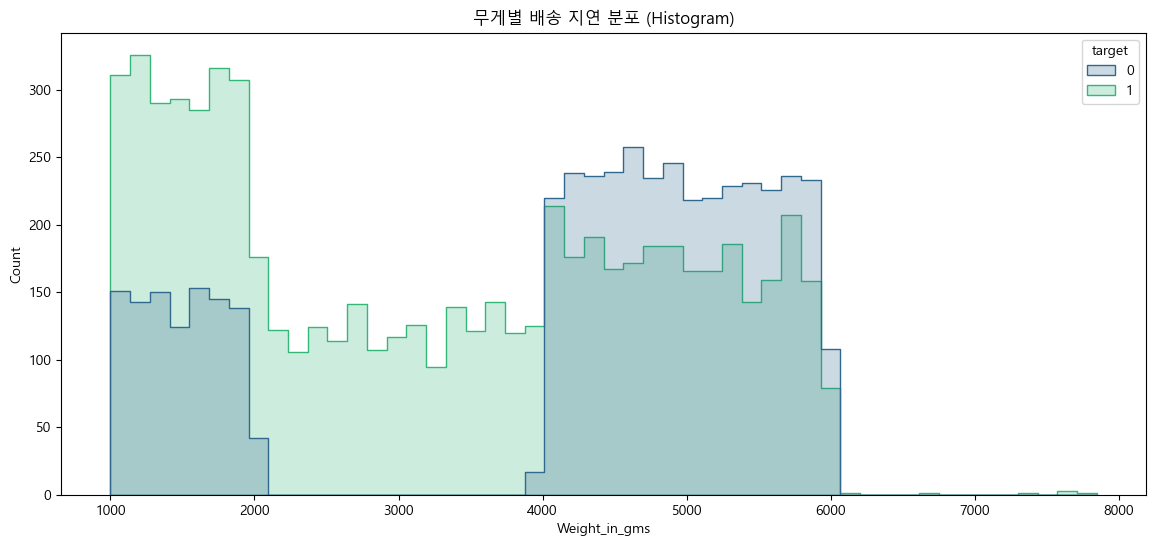

In [4]:
plt.figure(figsize=(14, 6))

# 히스토그램으로 지연 비율 확인
sns.histplot(x='Weight_in_gms', hue='target', data=df, element='step', palette='viridis', bins=50)
plt.title('무게별 배송 지연 분포 (Histogram)')
plt.show()

> **분석 결과 (Insight):**
> - 데이터가 **가벼운 구간(2000~4000g)**과 **무거운 구간(4000~6000g)**으로 명확히 나뉩니다.
> - **2000g~4000g 구간:** 배송 지연(`1`) 비율이 압도적으로 높습니다.
> - **4000g~6000g 구간:** 정시 도착(`0`) 비율이 상대적으로 높습니다.
> - **결론:** 무게는 단순 선형 관계가 아니므로, **구간화(Binning)**하여 사용하는 것이 필수적인 핵심 변수입니다.

## 3. 제품 중요도 (Product_importance) 분석
**근거:** 'high' 중요도일 때 지연 패턴이 다른지 확인합니다.

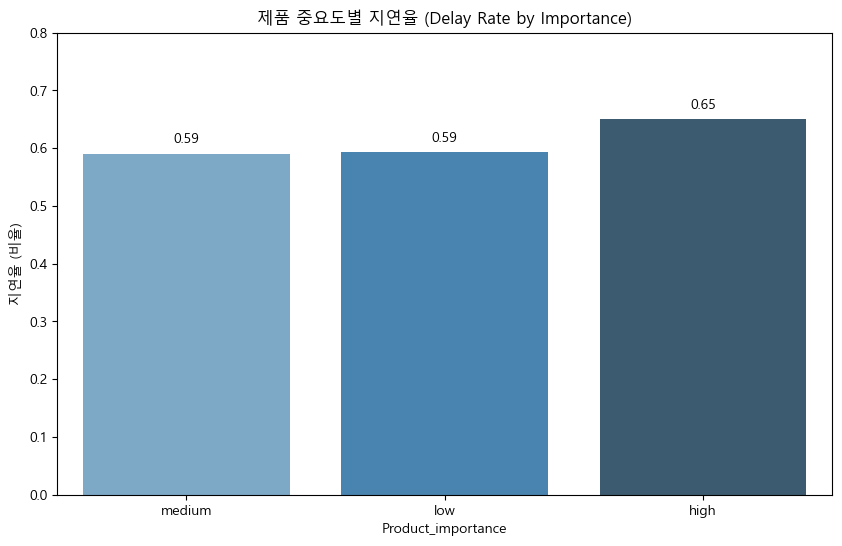

In [5]:
# 중요도별 지연율 계산
imp_delay = df.groupby('Product_importance')['target'].mean().sort_values()

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=imp_delay.index, y=imp_delay.values, palette='Blues_d')
plt.title('제품 중요도별 지연율 (Delay Rate by Importance)')
plt.ylabel('지연율 (비율)')
plt.ylim(0, 0.8)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

> **분석 결과 (Insight):**
> - `high` 중요도의 제품은 `low`나 `medium`에 비해 **지연율이 약간 더 높습니다** (약 65% vs 59%).
> - 차이가 아주 크지는 않지만, VIP 고객이나 중요 화물의 경우 지연 가능성이 더 높다는 것은 비즈니스적으로 **의미 있는 패턴**일 수 있습니다.
> - **결론:** 중요도는 영향력이 할인액만큼 크진 않지만, 고려해야 할 유의미한 변수입니다.

## 4. 무의미한 변수 비교 (성별, 창고)
**근거:** 카테고리별로 지연율 차이가 거의 없어 중요도가 떨어짐을 시각화합니다.

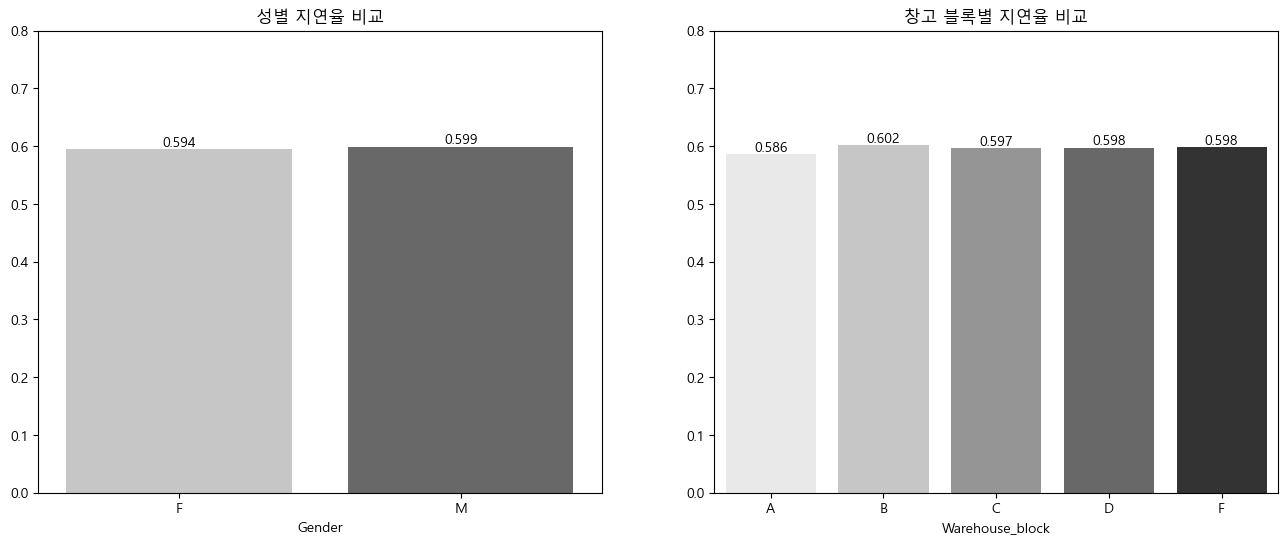

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# 성별
gender_delay = df.groupby('Gender')['target'].mean()
sns.barplot(x=gender_delay.index, y=gender_delay.values, ax=ax[0], palette='Greys')
ax[0].set_title('성별 지연율 비교')
ax[0].set_ylim(0, 0.8)
for p in ax[0].patches:
    ax[0].annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='bottom')

# 창고 블록
block_delay = df.groupby('Warehouse_block')['target'].mean()
sns.barplot(x=block_delay.index, y=block_delay.values, ax=ax[1], palette='Greys')
ax[1].set_title('창고 블록별 지연율 비교')
ax[1].set_ylim(0, 0.8)
for p in ax[1].patches:
    ax[1].annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='bottom')

plt.show()

> **분석 결과 (Insight):**
> - **성별:** 남여 간 지연율 차이는 소수점 단위로 거의 동일합니다.
> - **창고 블록:** A, B, C, D, F 블록 간 지연율 차이가 크지 않습니다.
> - **결론:** 이 변수들은 모델 학습 시 노이즈로 작용하거나, 영향력이 미미할 가능성이 높습니다.